In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
## Load dataset
K = 3
N_c, N_s, N_t = 60, 64, 60
N = N_c+N_s+N_t
data_path = data_dir + "ncmm/shapes_c=%d_s=%d_t=%d" % (N_c, N_s, N_t)

OB = torch.from_numpy(np.load(data_path + '/ob.npy')).float()
MU = torch.from_numpy(np.load(data_path + '/mu.npy')).float()
ANGLE = torch.from_numpy(np.load(data_path + '/angle.npy')).float()
STATE = torch.from_numpy(np.load(data_path + '/state.npy')).float()
## Hyper Parameters
NUM_DATASETS = OB.shape[0]

## Train Parameters
NUM_EPOCHS = 500

D = 2
SAMPLE_SIZE = 10
BATCH_SIZE = 20
NUM_BATCHES = int((NUM_DATASETS / BATCH_SIZE))

CUDA = torch.cuda.is_available()
DEVICE = 1
RECON_SIGMA = torch.ones(1) * 0.2
# lg2pi = torch.log(torch.ones(1) * 2 * math.pi)
PATH = 'dec-%dpts-%dsamples' % (N_c+N_s+N_t, SAMPLE_SIZE)
## MOdel Parameters
NUM_HIDDEN_LOCAL = 64
NUM_HIDDEN = 32
NUM_NSS = 8
LEARNING_RATE = 1e-3
Train_Params = (NUM_EPOCHS, K, D, SAMPLE_SIZE, BATCH_SIZE, CUDA, DEVICE, PATH)

In [3]:
# a = STATE[0].repeat(SAMPLE_SIZE, 1, 1)
# b = OB[0].repeat(SAMPLE_SIZE, 1, 1)
# labels = a.argmax(-1).unsqueeze(-1).repeat(1, 1, D)
# torch.gather(b, -2, labels).shape

In [4]:
from decoder_shapes import *
dec_x = Dec_x(D, NUM_HIDDEN, RECON_SIGMA, CUDA, DEVICE)

if CUDA:
    with torch.cuda.device(DEVICE):
        dec_x.cuda()
optimizer =  torch.optim.Adam(list(dec_x.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

In [5]:
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    LOSS = 0.0
    indices = torch.randperm(NUM_DATASETS)
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        ob = OB[batch_indices]
        state = STATE[batch_indices]
        mu = MU[batch_indices]
        angle = ANGLE[batch_indices]
        ob_embedding = torch.cat((ob, state, angle), -1)
        ob_embedding = shuffler(ob_embedding).repeat(SAMPLE_SIZE, 1, 1, 1)
        mu = mu.repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            with torch.cuda.device(DEVICE):
                ob_embedding =ob_embedding.cuda()
                mu = mu.cuda()
        ob = ob_embedding[:, :, :, :2]
        state = ob_embedding[:, :, :, 2:-1]
        angle = ob_embedding[:, :, :, -1].unsqueeze(-1)
        p = dec_x(ob, state, angle, mu)
        loss =  - p['likelihood'].log_prob.sum()
        ## gradient step
        loss.backward()
        optimizer.step()  
        LOSS += loss
    if epoch % 10 == 0:
        time_end = time.time()
        print('epoch=%d, loss=%.4f (%ds)' % (epoch, LOSS / NUM_BATCHES, time_end - time_start))
        time_start = time.time()

epoch=0, loss=1221840.7500 (1s)
epoch=10, loss=-28623.9805 (0s)
epoch=20, loss=-38934.1289 (1s)
epoch=30, loss=-40360.1914 (1s)
epoch=40, loss=-41061.2461 (1s)
epoch=50, loss=-41461.5312 (0s)
epoch=60, loss=-41701.6641 (1s)
epoch=70, loss=-41874.8906 (1s)
epoch=80, loss=-42021.0977 (1s)
epoch=90, loss=-42150.2930 (1s)
epoch=100, loss=-42281.6250 (1s)
epoch=110, loss=-42405.4141 (1s)
epoch=120, loss=-42524.3477 (1s)
epoch=130, loss=-42641.0352 (1s)
epoch=140, loss=-42745.3086 (1s)
epoch=150, loss=-42832.9375 (1s)
epoch=160, loss=-42908.6172 (1s)
epoch=170, loss=-42968.3555 (0s)
epoch=180, loss=-43028.3594 (1s)
epoch=190, loss=-43096.2734 (1s)
epoch=200, loss=-43183.0156 (0s)
epoch=210, loss=-43277.5469 (0s)
epoch=220, loss=-43359.8359 (0s)
epoch=230, loss=-43432.4492 (1s)
epoch=240, loss=-43480.6992 (1s)
epoch=250, loss=-43521.0156 (1s)
epoch=260, loss=-43551.4727 (0s)
epoch=270, loss=-43578.6758 (1s)
epoch=280, loss=-43602.0156 (1s)
epoch=290, loss=-43622.0781 (1s)
epoch=300, loss=-436

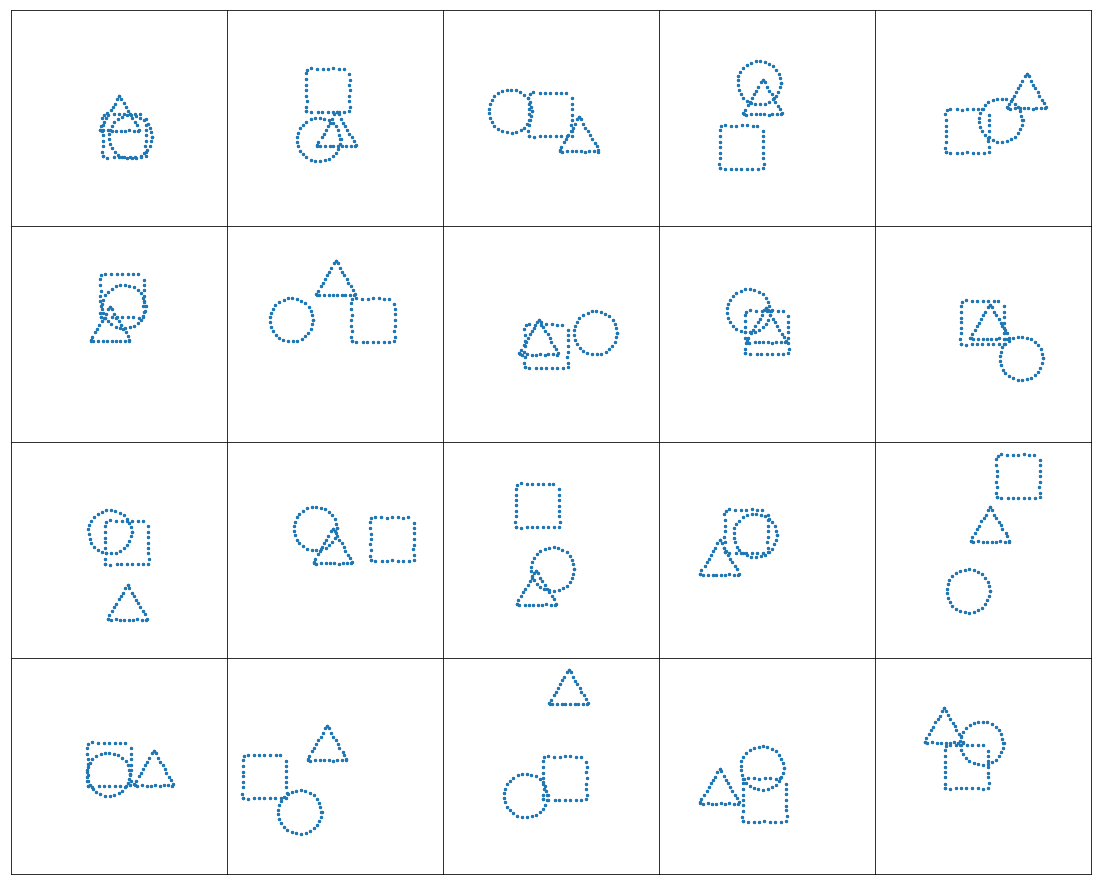

In [6]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

def plot_recon(recon, path, page_width, bound):
    B, N, D = recon.shape
    gs = gridspec.GridSpec(int(B / 5), 5)
    gs.update(left=0.0 , bottom=0.0, right=1.0, top=1.0, wspace=0, hspace=0)
    fig = plt.figure(figsize=(page_width,page_width*4/5))
    for b in range(B):
        ax = fig.add_subplot(gs[int(b / 5), int(b % 5)])
        ax.scatter(recon[b, :, 0], recon[b, :, 1], s=5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylim(-bound, bound)
        ax.set_xlim(-bound, bound)
    
indices = torch.randperm(NUM_DATASETS)
batch_indices = indices[0*BATCH_SIZE : (0+1)*BATCH_SIZE]
ob = OB[batch_indices]
state = STATE[batch_indices]
mu = MU[batch_indices]
angle = ANGLE[batch_indices]


ob_embedding = torch.cat((ob, state, angle), -1)
ob_embedding = shuffler(ob_embedding).repeat(SAMPLE_SIZE, 1, 1, 1)
mu = mu.repeat(SAMPLE_SIZE, 1, 1, 1)
if CUDA:
    with torch.cuda.device(DEVICE):
        ob_embedding =ob_embedding.cuda()
        mu = mu.cuda()
ob = ob_embedding[:, :, :, :2]
state = ob_embedding[:, :, :, 2:-1]
angle = ob_embedding[:, :, :, -1].unsqueeze(-1)
p = dec_x(ob, state, angle, mu)

recon_mu = p['likelihood'].dist.loc[0].cpu().data.numpy()
plot_recon(recon_mu, PATH, 15, 10)

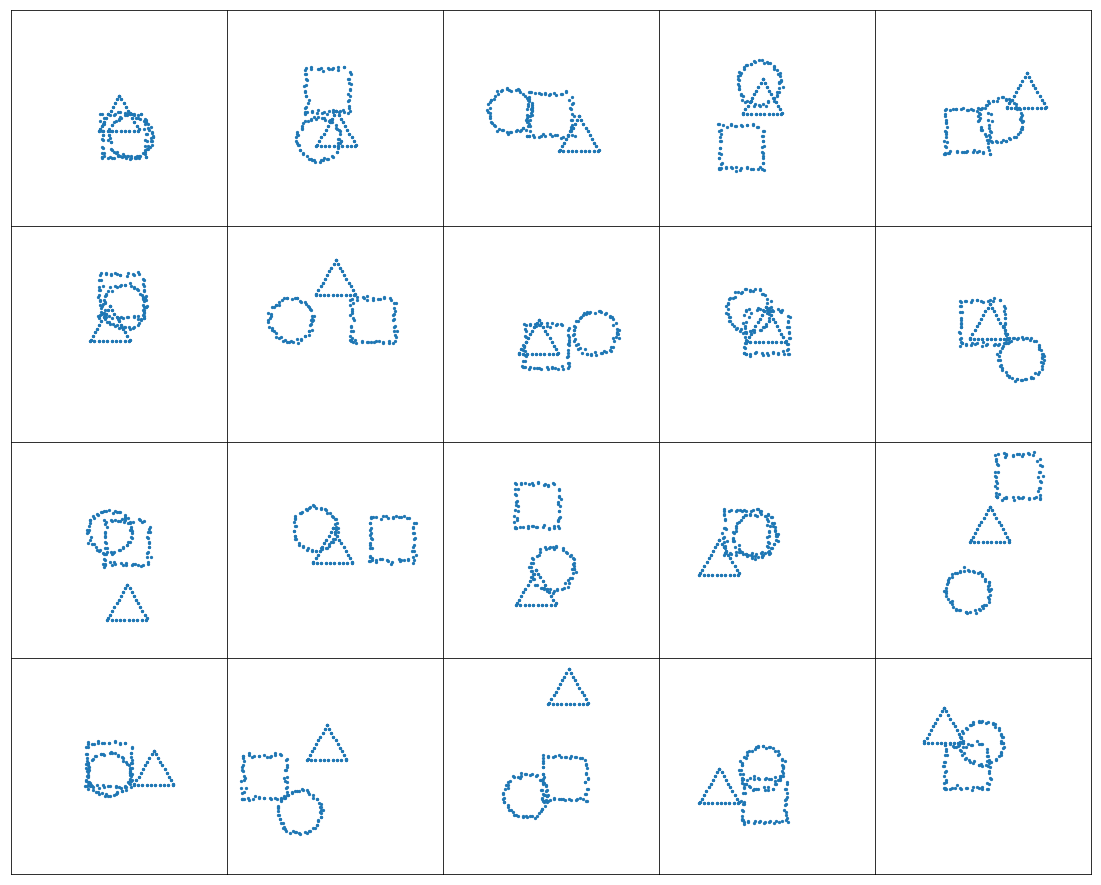

In [7]:
plot_recon(ob[0].cpu().data.numpy(), PATH, 15, 10)